In [ ]:
from google.colab import files

uploaded = files.upload()

Saving sms_data.xlsx to sms_data.xlsx


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns

CURRENT_DIR = os.getcwd()
file_path = os.path.join(CURRENT_DIR, "sms_data.xlsx")
# save_path = os.path.join(CURRENT_DIR, "Result", "preprocessed_train.csv")

print("현재 작업 디렉토리:", CURRENT_DIR)

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"🚨 파일을 찾을 수 없습니다! 경로를 확인하세요: {file_path}")
    raise FileNotFoundError(f"파일이 없습니다: {file_path}")

현재 작업 디렉토리: /content


# 데이터 확인

In [ ]:
df.head()

,body,spam,type,생성여부
0,"[신한은행,내부통지] 님 신한 쏠(SOL) 서비스 가입이 완료되었습니다.",0,0,0
1,"[신한은행,사고예방] 님 간편이체가 (재)등록 되었습니다!",0,0,0
2,모코헤어살롱\n님\n01월16일\n14시00분\n예약되었습니다. \n감사합니다.,0,0,0
3,님의 통합회원 임시비밀번호는 db^46822 입니다. 유웨이 동일 적용. 진학공통원서,0,0,0
4,어디,0,0,0


In [ ]:
df.columns

Index(['body', 'spam', 'type', '생성여부'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21663 entries, 0 to 21662
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    21663 non-null  object
 1   spam    21663 non-null  int64 
 2   type    21663 non-null  object
 3   생성여부    21663 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 677.1+ KB


- 21633개 데이터
  - body : object
  - spam : int
  - type : object
  - 생성여부 : int

In [ ]:
df["type"].unique()

array([0, '기타', '광고', '주식/투자', '도박', '선거/정치', '성인', '대출/금융', '대리운전'],
      dtype=object)

- 0 : ham(일반) 문자

In [ ]:
df['type'].value_counts()

,count
type,
광고,7307
0,6327
대출/금융,3143
주식/투자,2697
성인,1003
도박,676
선거/정치,334
기타,155
대리운전,21


- type : 9개
  - 기타의 경우, 사용자조차 구분하지 못하는 type이라 모델이 분류하기에 다소 어려움이 있다고 판단하여 제거
  - 대리운전의 경우, 데이터의 수가 적어 학습에 제대로 활용을 못함. 제거

## 기타/대리운전 제거

In [ ]:
df=df[df["type"]!='기타']
df=df[df["type"]!='대리운전']

- 스팸 종류 : 광고, 주식/투자, 도박, 선거/정치, 성인, 대출/금융, 대리운전
- 스팸이 아닐 경우, type은 0

In [ ]:
df["type"].value_counts()

,count
type,
광고,7307
0,6327
대출/금융,3143
주식/투자,2697
성인,1003
도박,676
선거/정치,334


- 광고성 문자가 스팸 문자 중 가장 높은 수를 차지함

In [ ]:
df["type"] = df["type"].replace(0, '일반')

In [ ]:
df['type'].unique()

array(['일반', '광고', '주식/투자', '도박', '선거/정치', '성인', '대출/금융'], dtype=object)

- 0을 '일반' 문자열로 대체하여 object형으로 맞춰줌

## 라벨인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['type_encoded'] = encoder.fit_transform(df['type'])

In [ ]:
print(df[['type', 'type_encoded']].drop_duplicates())

       type  type_encoded
0        일반             5
203      광고             0
384   주식/투자             6
1462     도박             2
1583  선거/정치             3
1620     성인             4
2405  대출/금융             1


In [ ]:
print(encoder.classes_)

['광고' '대출/금융' '도박' '선거/정치' '성인' '일반' '주식/투자']


- 다중 분류 모델이 예측 결과를 나타낼 수 있도록 라벨 인코딩 진행
  - 0 : 광고
  - 1 : 대출/금융
  - 2 : 도박
  - 3 : 선거/정치
  - 4 : 성인
  - 5 : 일반
  - 6 : 주식/투자

- 총 7개의 type

## 데이터 시각화

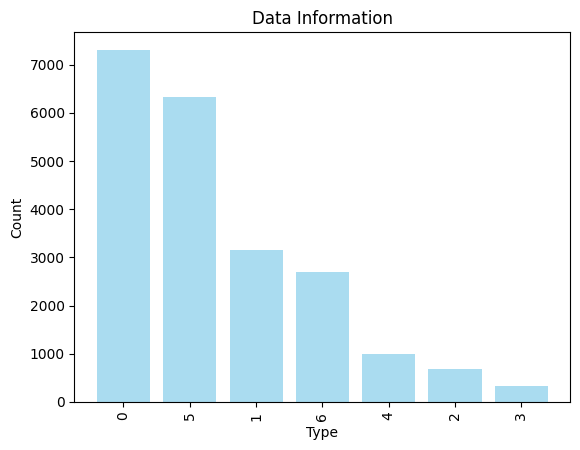

In [ ]:
count = df["type_encoded"].value_counts()
plt.bar(count.index.astype(str), count.values, color='skyblue', alpha=0.7)
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Data Information")
plt.show()

- 광고(0)가 제일 많고, 선거/정치(3)이 제일 적음

## train& test데이터 나누기

In [ ]:
from sklearn.model_selection import train_test_split

x = df['body']
y = df['type_encoded']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, stratify = y, random_state = 42
)

## 한글 형태소에 따라 분류

In [ ]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 39.0 MB/s eta 0:00:00


In [ ]:
x_train = x_train.astype(str)
x_test = x_test.astype(str)

- 한글 조사들 날려주기(의미를 파악하는데에 관여 X/기존 버전에서 보다 추가)

In [ ]:
stopwords = ['는', '가', '이', '을', '를', '에', '에서', '으로', '로', '도','만', '뿐', '까지', '부터', '과', '와', '하고', '하며', '다', '죠', '요', '네', '군', '께서', '이다', '임', '듯', '게']

konlpy
- 쓰임새 : 문장에서 각 단어의 품사와 형태를 분석하여 의미 있는 최소 단위(형태소)로 나누는 작업

In [ ]:
from konlpy.tag import Okt
from tqdm import tqdm

okt = Okt()

X_train = []
X_test = []

# 토큰화 (불용어 제거)
for sentence in tqdm(x_train):
    tokenized_sentence = okt.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

for sentence in tqdm(x_test):
    tokenized_sentence = okt.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 4298/4298 [00:52<00:00, 81.94it/s]


## 사전 만들어보기(형태소로 나눈 단어들을 저장하는 사전을 만든다 생각)

원래는 tokenzier 사용했는데, 사전 만들어서 빈도수 낮은 단어 (데이터 전체에서 3번 이하 등장)들을 잘라주면 모델의 결과값이 좋아질 것이라 기대함

-> 노이즈 제거, 차원 축소, 과적합 방지

In [ ]:
from collections import Counter

word_list = []
for message in X_train:
    for words in message:
      word_list.append(words)

word_count = Counter(word_list)
print('총 단어 :', len(word_count))

vocab = sorted(word_count, key=word_count.get, reverse=True)
print('빈도수 높은 단어 10개')
print(vocab[:10])

총 단어 : 44921
빈도수 높은 단어 10개
['@', 'ifg', 'ifg@ifg', '*', ')', '.', '**', '(', ']', ':']


In [ ]:
threshold = 4
total_cnt = len(word_count) # 단어 수
rare = 0 # 빈도수 < threshold 단어 개수
total_freq = 0 # 훈련 데이터의 전체 단어 횟수 총 합
rare_freq = 0 # 등장 횟수가 임계보다 작은 단어의 등장 횟수의 총 합


for key, value in word_count.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 임계보다 작으면
    if(value < threshold):
        rare = rare + 1
        rare_freq = rare_freq + value

print('사전 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare))
print("사전에서 희귀 단어의 비율:", (rare / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

사전 크기 : 44921
등장 빈도가 3번 이하인 희귀 단어의 수: 29789
사전에서 희귀 단어의 비율: 66.31419603303577
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.212576129928411


위에 보면 사전에서 차지하는 비중은 큰데, 실제로는 잘 안쓰이는걸 볼 수 있음.
(단어 종류 중 희귀 단어가 많아도, 전체 글에서 차지하는 비중은 적다)

즉, 노이즈로 작용할 수 있다 판단. 아래에서 잘라줌

In [ ]:
#등장 횟수 3 이하인 단어 제거.
vocab_size = total_cnt - rare
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 15132


## 텍스트 정수 인코딩(text-to-sequence) 과정

단어들을 고유한 정수에 매핑하여 문장을 정수 시퀀스로 바꾸는 전처리 과정(기계가 이해할 수 있는 언어로 바꿔준다 생각해도 될듯)

In [ ]:
word_index = {}
word_index['<PAD>'] = 0 #비어있는 거 채우기 용도
word_index['<UNK>'] = 1 # 모르는 단어 채우기 용도

for index, word in enumerate(vocab) :
  word_index[word] = index + 2

print('단어 <PAD>와 맵핑되는 정수 :', word_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_index['<UNK>'])

# 예시
print('단어 부동산과 맵핑되는 정수 :', word_index['부동산'])
print('단어 선거와 맵핑되는 정수 :', word_index['선거'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 부동산과 맵핑되는 정수 : 1895
단어 선거와 맵핑되는 정수 : 9038


vocab: 학습 텍스트에서 얻은 고유 단어 리스트

PAD: 패딩을 위한 특수 토큰 → 모델 입력 길이 맞추기용

UNK: 사전에 없는 미지의 단어 처리용 토큰

모든 단어를 고유한 정수에 매핑하는 작업


tokenizer는 사전 생성부터 인코딩까지 전과정을 통합 처리하도록 설계되어 있어
명시적으로 정의 한 사전을 활용하는 경우 내부구조를 강제로 초기화 시켜야해서 번거로움

In [ ]:
def text_to_seq(tokenized,word_index):
    sequences = []
    for sentence in tokenized:
        encoded = []
        for word in sentence:
            index = word_index.get(word, word_index["<UNK>"])  # 모르는 단어는 UNK로 처리
            encoded.append(index)
        sequences.append(encoded)
    return sequences

# 인코딩 수행
encoded_X_train = text_to_seq(X_train,  word_index)
encoded_X_test = text_to_seq(X_test,  word_index)

# 확인
print("인코딩된 첫 번째 문장:", encoded_X_train[0])
print("인코딩된 열한 번째 문장:", encoded_X_train[10])

인코딩된 첫 번째 문장: [15, 39, 26, 609, 21, 842, 187, 259, 6, 5707, 3504, 1, 42, 3630, 518, 3505, 5]
인코딩된 열한 번째 문장: [423, 3350, 56, 671]


In [ ]:
print(len(encoded_X_train))
print(len(encoded_X_test))

17189
4298


### 매핑된 문장 확인

In [ ]:
index_to_word = {}
for key, value in word_index.items():
    index_to_word[value] = key

for i in range(100, 105):
  decoded_sample = [index_to_word[word] for word in encoded_X_train[i]]
  print(f'기존의 {i}번째 샘플 :', X_train[i])
  print(f'복원된 {i}번째 샘플 :', decoded_sample)
  print('\n')

기존의 100번째 샘플 : ['(', '광고', ')', '관절', '건강', '호', '관원', '프리미엄', '골드', '********', 'ifg@ifg', "@'****", '년', "'", '만사', '술술', '.', '관절', '건강', '술술', '<', '호', '관원', '.', '최대', '무료', '증정', '>', '~', '술술', '.****', '년', '가기전에', '.', '절대', '.', '놓치면', '.', '안되세요', '^^', 'ifg@ifg', '@', '것', '저', '것', '.', '드셨어도', '.', '관절', '건강', '.', '제일', '.', '좋다는', '<', '관절', '건강', '호', '관원', '>**', '년', '.', '훌쩍', '.', '넘도록', '.', '인상', '.', '된', '적', '.', '없었지만', '▶', '원자재', '값', '인상', '▶', '**/**', '일', '.', '인상', '확정', 'ifg@ifg', '@', '▶', '단', '*', '재구매', '고객', '님', '/**', '년', '전보', '~', '더', '저렴', '<**', '월', '**', '일', '>', 'ifg@ifg', '@', '★', '*', '달', '가격', '면', '★', '여기', '부터는', '[', '모두', '무료', ']', '★', '호', '관원', '*', '달', '분', '★', '황궁', '침향', '단', '*', '★', '관절', '더하기', '혈행', '<', '신제품', '>', '★', '호', '관원', '**', '포', '▶', '호', '관원', '크림', '▶', '인슈단', '▶', '**', '개월무', '이자', '★', '정기', '배송', '서비스', '★', '소중한', '.', '고객', '님', '은', '.', '모두', '.', '받으실수있습니다', '▶', '본사', '담당', '/********

## train 데이터 문장 길이 분포 시각화

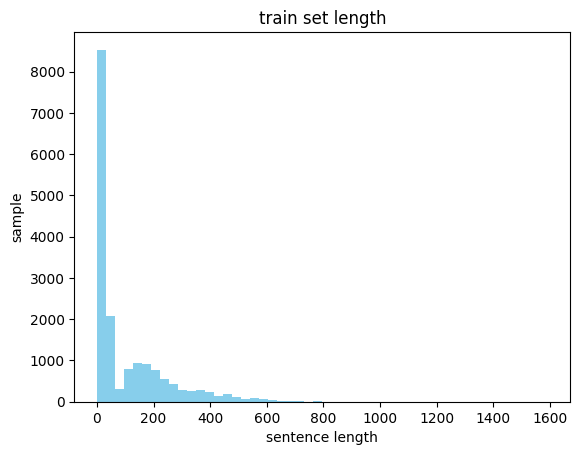

최대 길이: 1593
최소 길이: 0
평균 길이: 108.89522368956891
95% 문장 길이 이하: 406.0
99% 문장 길이 이하: 589.119999999999


In [ ]:
# 문장 길이 리스트 생성
train_lengths = [len(sentence) for sentence in encoded_X_train]

# 분포 시각화
plt.hist(train_lengths, bins=50, color='skyblue')
plt.xlabel('sentence length')
plt.ylabel('sample')
plt.title('train set length')
plt.show()

# 통계 정보 확인
print("최대 길이:", np.max(train_lengths))
print("최소 길이:", np.min(train_lengths))
print("평균 길이:", np.mean(train_lengths))
print("95% 문장 길이 이하:", np.percentile(train_lengths, 95))
print("99% 문장 길이 이하:", np.percentile(train_lengths, 99))

- 길이가 0인 문장은 제거

In [ ]:
zero_length_index = [i for i, seq in enumerate(encoded_X_train) if len(seq) == 0]
print("길이가 0인 문장 인덱스들:", zero_length_index)
print("길이가 0인 문장 개수:", len(zero_length_index))

길이가 0인 문장 인덱스들: [1021, 1615, 2084, 2196, 2916, 3462, 3650, 4074, 6797, 6929, 7088, 9049, 9282, 9576, 11216, 11248, 13021, 13270, 13323, 14098, 14525, 15789, 16275, 16984]
길이가 0인 문장 개수: 24


In [ ]:
zero_length = set(zero_length_index)
encoded_X_train = [x for i, x in enumerate(encoded_X_train) if i not in zero_length]
y_train = [x for i, x in enumerate(y_train) if i not in zero_length]

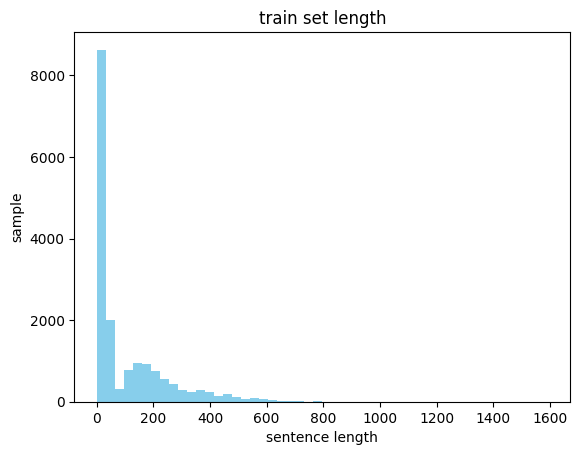

최대 길이: 1593
최소 길이: 1
평균 길이: 109.04748033789689
95% 문장 길이 이하: 406.0
99% 문장 길이 이하: 589.3600000000006


In [ ]:
# 문장 길이 리스트 생성
train_lengths = [len(sentence) for sentence in encoded_X_train]

# 분포 시각화
plt.hist(train_lengths, bins=50, color='skyblue')
plt.xlabel('sentence length')
plt.ylabel('sample')
plt.title('train set length')
plt.show()

# 통계 정보 확인
print("최대 길이:", np.max(train_lengths))
print("최소 길이:", np.min(train_lengths))
print("평균 길이:", np.mean(train_lengths))
print("95% 문장 길이 이하:", np.percentile(train_lengths, 95))
print("99% 문장 길이 이하:", np.percentile(train_lengths, 99))

- 길이가 0인 문장은 제거 완료

## 문장 길이 기반 padding

하는 이유 : 각 문장들의 길이가 다르다. 그러나 학습모델에 넣으려면 같은 길이의 데이터(벡터) 필요! 즉 가장 긴 문장을 기반으로 규격을 맞추고 그보다 짧은 문장 뒤는 0으로 채워서 공란으로 두는 개념

확인 결과 지나치게 긴 문장 존재(통계적으로). 이상치라 판단 상위 1%를 기준으로 그 이상은 잘라주기(1421을 기준으로 잡게되면 다른거도 1421 기준으로 맞춰줘야함 -> 경량화를 하기 위해 실행)

In [ ]:
train_lengths = [len(x) for x in encoded_X_train]

# 99% 커버하는 최대 길이 계산
max_len = int(np.percentile(train_lengths, 99))
print(f"99%  길이 커트라인: {max_len}")

# 패딩 함수
def pad_and_truncate(sequences, target_len, padding_value=0):
    result = []
    for seq in sequences:
        if len(seq) >= target_len:
            trimmed = seq[:target_len]
        else:
            trimmed = seq + [padding_value] * (target_len - len(seq))
        result.append(trimmed)
    return np.array(result, dtype=np.int32)

# 적용
padded_X_train = pad_and_truncate(encoded_X_train, max_len)
padded_X_test = pad_and_truncate(encoded_X_test, max_len)

print("패딩된 train 데이터 shape:", padded_X_train.shape)

99%  길이 커트라인: 589
패딩된 train 데이터 shape: (17165, 589)


In [ ]:
# 저장
np.save("padded_X_train.npy", padded_X_train)
np.save("padded_X_test.npy", padded_X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

In [ ]:
print(len(encoded_X_train), len(y_train))

17165 17165


# 모델 설계 시작

In [ ]:
# 불러오기
padded_X_train = np.load("padded_X_train.npy")
padded_X_test = np.load("padded_X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

1. 임베딩 : 사전내 단어들을 문장 기반으로 학습해서, 문장 내에서특정 단어들이 같은 목적(스팸/일반)에 기여하는지를 통계적으로 파악

2. Bidirectional LSTM : 양방향 LSTM으로 단방향이던 LSTM을 개량하여 앞뒤 문맥을 파악할 수 있게 함. 전체 맥락을 파악하는 능력 향상. 성능은 올라가겠지만 속도 및 무게에서 trade-off 존재
(도입 근거 : 기존 모델이 probability가 0.5근처에서 놀고 있었고->모델이 confidence가 없음->underfitting으로 판단, 데이터는 충분하다고 생각하기에 모델을 고도화하자는 쪽으로 결정)

3. drop-out : 학습 단계 마다 일부 뉴런을 랜덤하게 비활성화 시켜서 신경망이 특정 뉴런에 과의존 하는걸 방지

4. softmax : 다중 분류 모델이기 때문에 출력층의 활성화 함수는 softmax로 설정

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Bidirectional

- 콜백 함수 설정

In [ ]:
es_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

cp_cb = ModelCheckpoint('best_model.keras', monitor = 'val_loss',
                        save_best_only = True, mode = 'min')

In [ ]:
# 하이퍼파라미터 설정
embedding_dim = 128
lstm_units = 128

# 모델 구성
model = Sequential()
model.add(Embedding(input_dim=vocab_size + 2, output_dim=embedding_dim, input_shape=(max_len,), mask_zero=False))
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 589, 128)       │     1,937,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,202,119 (8.40 MB)

 Trainable params: 2,202,119 (8.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 학습
history = model.fit(
    padded_X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[es_cb, cp_cb],
    verbose=1
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6323 - loss: 1.0840 - val_accuracy: 0.8940 - val_loss: 0.3611
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9287 - loss: 0.2503 - val_accuracy: 0.9528 - val_loss: 0.1607
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9706 - loss: 0.1098 - val_accuracy: 0.9645 - val_loss: 0.1303
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9828 - loss: 0.0746 - val_accuracy: 0.9688 - val_loss: 0.1132
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9915 - loss: 0.0367 - val_accuracy: 0.9688 - val_loss: 0.1152
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9942 - loss: 0.0262 - val_accuracy: 0.9706 - val_loss: 0.1136
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9971 - loss: 0.0144 - val_accuracy: 0.9744 - val_loss: 0.1124
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9978 - loss: 0.0115 - val_accu

- 총 13번 epoch 학습

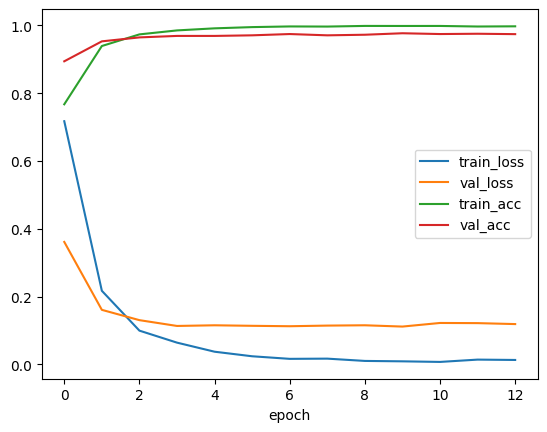

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
print(es_cb.stopped_epoch)

12


- patience : 3
- stopped_epoch : 12
  - epoch = 10이 best model

In [ ]:
# 테스트 정확도 및 손실 평가
test_loss, test_accuracy = model.evaluate(padded_X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9822 - loss: 0.0908
Test Accuracy: 0.9800
Test Loss: 0.0989


In [ ]:
# 예측 확률
y_pred_prob = model.predict(padded_X_test)

# 라벨
y_pred = y_pred_prob.argmax(axis=1)

135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [ ]:
print(y_pred)

[5 5 5 ... 1 6 4]


In [ ]:
y_pred.shape

(4298,)

# 결과값

In [ ]:
print(encoder.classes_)

['광고' '대출/금융' '도박' '선거/정치' '성인' '일반' '주식/투자']


In [ ]:
from sklearn.metrics import classification_report

target = ['광고', '대출/금융', '도박', '선거/정치', '성인', '일반', '주식/투자']

report = classification_report(y_test, y_pred, target_names=target, output_dict = True, zero_division=0)
report_df = pd.DataFrame(report).transpose()

In [ ]:
report_df

,precision,recall,f1-score,support
광고,0.987110,0.995212,0.991144,1462.000000
대출/금융,0.996716,0.965024,0.980614,629.000000
도박,0.896296,0.896296,0.896296,135.000000
선거/정치,0.833333,0.970149,0.896552,67.000000
성인,0.960199,0.960199,0.960199,201.000000
일반,0.991277,0.988142,0.989707,1265.000000
주식/투자,0.964815,0.966605,0.965709,539.000000
accuracy,0.979991,0.979991,0.979991,0.979991
macro avg,0.947107,0.963090,0.954317,4298.000000
weighted avg,0.980438,0.979991,0.980090,4298.000000


기존 모델 결과(BILSTM)

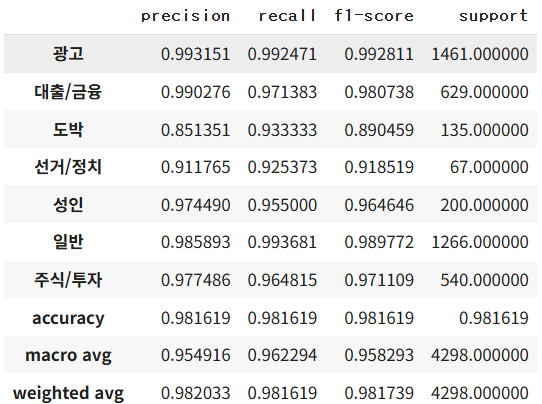